<a href="https://colab.research.google.com/github/pmcwhannel/NBA-analytics/blob/main/ShortChartML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import timeit as tt
shot_chart_path = '/content/drive/MyDrive/CS631-Project/all_shot_chart_data/part-00*'
# [player key, qtr, make/miss, TOP_dist, LEFT_dist, time remaining, dist shot,
# game score, players_team ,team_1=away, team_2=home, year] + [opponent]
# Names of the variables for indexing.
PK = 0   # Player Key
QTR = 1  # Quarter
SHOT = 2 # make/miss
TD = 3   # distance from top (pixels)
LD = 4   # distance from left (pixels)
TR = 5   # time remaining
DS = 6   # distance of shot from bucket (ft)
GS = 7   # game score after the shot
TM = 8   # This data will be changed from city name to 3-letter abreviation. To match AW and HM value.
AW = 9   # Away team (3-letter abreviation)
HM = 10  # Home team (3-letter abreviation)
YR = 11  # Year (year the seasons ends in)
OPP = 12 # This will be added later

### Setup Spark

In [3]:
%%shell
apt-get update -qq > /dev/null
apt-get install openjdk-8-jdk-headless -qq > /dev/null
wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
tar xf spark-2.4.7-bin-hadoop2.7.tgz
pip install -q findspark

In [4]:
%%shell
pip install --upgrade pip
pip install lxml
git clone https://github.com/pmcwhannel/NBA-analytics.git
mv NBA-analytics NBAanalytics # So importing functions is easy

Cloning into 'NBA-analytics'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 41 (delta 17), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (41/41), done.


In [5]:
# Have to rename drive to get rid of NBA-analytics -> NBAanalytics
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext(appName="YourTest", master="local[*]")

In [6]:
# Read in shooter data
def find_opp(x):
  '''
  Identify all shots against a single opposing team.
  '''
  if x[TM] == x[AW]: 
    opponent = x[HM] # home team is who shot is against
  else:
    opponent = x[AW] # away team is who shot is against

  return x + [opponent]

def ply_tm_2_abrv(shooter,tm_2_abrv):
  '''
  input ply_tm: the data of the shooter
  input tm_2_abrv: linkage from PLAYER TEAM to 3-letter abreviation(s)
  '''
  if shooter[TM].upper() in tm_2_abrv.keys():
    for abrv in tm_2_abrv[shooter[TM].upper()]: # {'PLAYER TEAM':[abrv,...,]}
      if abrv == shooter[AW]:
        temp = abrv
        return shooter[:TM] + [temp] + shooter[TM+1:]
      elif abrv == shooter[HM]:
        temp = abrv
        return shooter[:TM] + [temp] + shooter[TM+1:]
    # didn't find a 3-letter abrv match
    return shooter[:TM] + ['MISSING'] + shooter[TM+1:] 
  else:
    # didn't find city name
    return shooter[:TM] + ['UNKNOWN'] + shooter[TM+1:]

### Add opponent shooting FG pct (Grid weighting).

In [7]:
# Team name as pulled from shot chart of shooter
# and mapping to a list of the possible 3-letter abbreviations 
tm_2_abrv ={'ATLANTA':['ATL'],
            'BOSTON':['BOS'],
            'INDIANA':['IND'],
            'CHICAGO':['CHI'],
            'TORONTO':['TOR'],
            'BROOKLYN':['BKN','BRK'],
            'VANCOUVER':['VAN'],
            'NEW YORK':['NYK'],
            'HOUSTON':['HOU'],
            'NEW ORLEANS':['NOP','NOH'],
            'CHARLOTTE':['CHA','CHH','CHO'],
            'DALLAS':['DAL'],
            'GOLDEN STATE':['GSW'],
            'OKLAHOMA CITY':['OKC'],
            'CLEVELAND':['CLE'],
            'LA CLIPPERS':['LAC'],
            'DENVER':['DEN'],
            'DETROIT':['DET'],
            'HOUSTON':['HOU'],
            'LA LAKERS':['LAL'],
            'MINNESOTA':['MIN'],
            'MEMPHIS':['MEM'],
            'MILWAUKEE':['MIL'],
            'MIAMI':['MIA'],
            'ORLANDO':['ORL'],
            'PHILADELPHIA':['PHI'],
            'PORTLAND':['POR'],
            'SACRAMENTO':['SAC'],
            'TORONTO':['TOR'],
            'SAN ANTONIO':['SAS'],
            'UTAH':['UTA'],
            'PHOENIX':['PHX','PHO'],
            'WASHINGTON':['WSH','WSB','WAS'],
            'SEATTLE':['SEA'],
            'NEW ORLEANS/OKLAHOMA CITY':['NOK'],
            'NEW ORLEANS/OKLAHOMA':['NOK'],
            'NEW JERSEY':['NJN']
            }

In [8]:
start = tt.default_timer()
rdd = sc.textFile(shot_chart_path).map(lambda x: x.split(',')).map(lambda x: ply_tm_2_abrv(x, tm_2_abrv)).map(lambda x: find_opp(x)).filter(lambda x: int(x[LD]) <= 500 and int(x[TD]) <= 472).cache()
print(rdd.count())
print('Time it took {}'.format(tt.default_timer() - start))
# Number of shooters with a city match but not an abbreviation match: 449472 (Problems fixed)
# Number of shooters without a city match at all: 113419 (Problems fixed)

4750345
Time it took 22.292592416999923


In [9]:
# Get only NOK for working on a subset of data # (13079 shots)
small_rdd = rdd.filter(lambda x: x[OPP] == 'NOK').cache()

In [10]:
import math
def normpdf(x, mean, sd):
  # Calcualte 1-D gaussian
  var = float(sd)**2
  denom = (2*math.pi*var)**.5
  num = math.exp(-(float(x)-float(mean))**2 / (2*var))
  return num/denom

def calc_distance(shooter, pos):
  # Calculate distance between player and sample shot
  # sqrt((x-x_i)**2 + (y-y_i)**2)
  return ((int(shooter[LD]) - pos[0])**2 + (int(shooter[TD]) - pos[1])**2)**(0.5)

def calc_opp_fg_pct(shooter,x):
  d = calc_distance(shooter,(x[1],x[2]))
  sd = 4   # THIS NEEDS TO BE TUNED MOST LIKELY
  mean = 0 # THIS SHOULD REMAIN ZERO
  weight = normpdf(d,mean,sd)
  return (x[0], weight) # (make/miss, weight)

def create_grid(x, nx, ny):
  # nx: number of partitions to cut x into
  # ny: number of partitions to cut y into

  x_lim = 500 # horizontal pixel limit
  y_lim = 472 # vertical pixel limit
  x_size = 1 + x_lim // nx # number of pixels per x grid
  y_size = 1 + y_lim // ny # number of pixels per y grid
  avg_fg_pct = [] # [(make_total,miss_total,avg_fg),...m]

  for i in range(0,ny):
    avg_fg_pct.append([])
    for j in range(0,nx):
      avg_fg_pct[i].append([0,0,0])


  for shot, x_pos, y_pos in x[1]:
    xid = x_pos // x_size
    yid = y_pos // y_size
    print()
    temp = avg_fg_pct[yid][xid]
    if shot == 'make':
      avg_fg_pct[yid][xid] =  [temp[0] + 1, temp[1], (temp[0] + 1) / (temp[0] + temp[1] + 1)]
    else:
      avg_fg_pct[yid][xid] = [temp[0], temp[1] + 1, temp[0] / (temp[0] + temp[1] + 1)]
  return (x[0], avg_fg_pct)

def add_opp_pct(x, nx, ny):
  # Calculate shooting pct of players from shooter's position
  #(key, ([shooter],[list of shots]))
  # x[0] => shooter
  # x[1] => list of shots
  shooter = x[1][0]
  x_lim = 500 # horizontal pixel limit
  y_lim = 472 # vertical pixel limit
  x_size = 1 + x_lim // nx # number of pixels per x grid
  y_size = 1 + y_lim // ny # number of pixels per y grid

  return shooter + [(x[1][1][int(shooter[TD]) // y_size][int(shooter[LD]) // x_size])[-1]]

In [11]:
# Create list of shots against a team
start = tt.default_timer()
nx = 37
ny = 36 
# ('NOK2007', (make/miss, x, y))
# Get rid of shots that are
rdd_shot_against_all = rdd.map(lambda x: (x[OPP] + x[YR], [(x[SHOT], int(x[LD]), int(x[TD]))])).reduceByKey(lambda x,y:
                        x+y).map(lambda x: create_grid(x, nx, ny)).cache() # [(key,[avg_fg_pct for each grid])] run time ~ 100 seconds

# Add opposing FG pct to MJ data
final_rdd = rdd.map(lambda x: (x[OPP] + x[YR],(x))).join(rdd_shot_against_all).map(lambda x:add_opp_pct(x, nx, ny)).cache()

print('Size of final rdd: {}'.format(final_rdd.count()))
print('It took {} to create the shooting history'.format(tt.default_timer() - start))

Size of final rdd: 4750345
It took 112.31856945399977 to create the shooting history


#### Save to textFile

In [12]:
final_rdd.map(lambda x: ','.join([str(itm) for itm in x])).saveAsTextFile('/content/drive/MyDrive/CS631-Project/' + 'all_shot_chart_data_opp_fg_pct_added_3736')


### Convert to Spark DataFrame

    -join on player average data
    -join on player metadata

In [13]:
# from pyspark.sql import SparkSession 
# import random 
# spark = SparkSession.builder.appName("YourTest").master("local[*]").config('spark.ui.port',
#                             random.randrange(4000,5000)).getOrCreate()
# sql_rdd = spark.read.csv(shot_chart_path)
# shots = rdd.toDF("PlayerKey","Qtr","Shot","TopDist","LeftDist","TimeRem","ShotDist","GmScore","Team","Away","Home","Year").cache()
# [player key, qtr, make/miss, TOP_dist, LEFT_dist, time remaining, dist shot,
# game score, players_team ,team_1=away, team_2=home, year]

### ML + Data vis and analysis

In [14]:
shooter_data = []
for i in range(0,20):
  if i <= 9:
    end_str = str(0) + str(i)
  else:
    end_str = str(i)
  lines = open('/content/drive/MyDrive/CS631-Project/' + 'all_shot_chart_data_opp_fg_pct_added_3736/part-000' + end_str ).readlines()
  
  print('Reading in part-000{}'.format(end_str))
  for line in lines:
    shooter_data.append([feature.strip() for feature in line.split(',')])


Reading in part-00000
Reading in part-00001
Reading in part-00002
Reading in part-00003
Reading in part-00004
Reading in part-00005
Reading in part-00006
Reading in part-00007
Reading in part-00008
Reading in part-00009
Reading in part-00010
Reading in part-00011
Reading in part-00012
Reading in part-00013
Reading in part-00014
Reading in part-00015
Reading in part-00016
Reading in part-00017
Reading in part-00018
Reading in part-00019


In [73]:
import pandas as pd
# Grab last 100,000 shots and make model
recent_shooters = shooter_data[4003000:4005000]
data = pd.DataFrame(recent_shooters, columns = ['PlayerKey','Quarter','FGM','TD','LD','TimeRemaining','Distance','GameScore','Team','Away','Home','Season','Opponent','OPPFGPct'])

In [74]:
data['FGM'] = data['FGM'].apply(lambda x: int(x=='make'))
data['Distance'] = data['Distance'].apply(lambda x: int(x))
data['OPPFGPct'] = data['OPPFGPct'].apply(lambda x: float(x))

#### Data visualizations and analysis

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt



<Figure size 1440x1440 with 0 Axes>

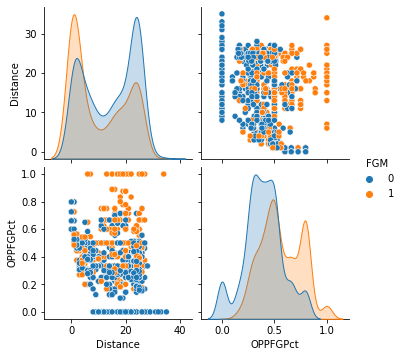

In [76]:
fig = plt.figure(figsize=(20,20))
sns.pairplot(data,hue='FGM')

In [19]:
print(500 // 37)
500 % (1+(500//37))

13


10

In [20]:
print(472 // 36)
472 % (1+(472//36))

13


10